# Complete Classification Model Training
This notebook trains the classification model with ALL features specified in the original requirements.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the complete regression model to get predictions
regression_model = joblib.load('../models/complete_regression_model.pkl')
print("Complete regression model loaded")

Complete regression model loaded


In [3]:
# Load the data
df = pd.read_csv('../data/processed/cleaned_rentals_25k.csv')
print(f"Dataset loaded with shape: {df.shape}")

# Basic preprocessing
df = df[df['price'] <= 7000]  # keep it manageable
df = df[df['price'] >= 100]   # remove listings with price of $0

print(f"After price filtering: {df.shape}")

Dataset loaded with shape: (25293, 169)
After price filtering: (25293, 169)


In [4]:
# Define ALL features as specified in original requirements
cols_to_keep = [
    "sq_feet", "beds", "baths", "type_Townhouse", "furnishing_Negotiable", "furnishing_Unfurnished",
    "type_Basement", "type_Condo Unit", "type_Main Floor", "latitude", "longitude", "price",
    "smoking_Non-Smoking", "smoking_Smoke Free Building", "cats_True", "dogs_True",
    "lease_term_6 months", "lease_term_Long Term", "lease_term_Negotiable", "lease_term_Short Term"
]

# Keep only available columns and drop NaN
available_cols = [col for col in cols_to_keep if col in df.columns]
df_clean = df[available_cols].dropna()

print(f"Final dataset shape: {df_clean.shape}")
print(f"Features included: {available_cols}")

Final dataset shape: (25293, 20)
Features included: ['sq_feet', 'beds', 'baths', 'type_Townhouse', 'furnishing_Negotiable', 'furnishing_Unfurnished', 'type_Basement', 'type_Condo Unit', 'type_Main Floor', 'latitude', 'longitude', 'price', 'smoking_Non-Smoking', 'smoking_Smoke Free Building', 'cats_True', 'dogs_True', 'lease_term_6 months', 'lease_term_Long Term', 'lease_term_Negotiable', 'lease_term_Short Term']


In [5]:
# Create predictions using regression model
X_features = df_clean[[col for col in available_cols if col != 'price']]
predicted_prices = regression_model.predict(X_features)

# Create labels based on actual vs predicted price
actual_prices = df_clean['price'].values
price_ratio = actual_prices / predicted_prices

# Define classification logic (same as original)
def classify_price(ratio):
    if ratio < 0.9:
        return "underpriced"
    elif ratio > 1.1:
        return "overpriced"
    else:
        return "fair"

labels = [classify_price(ratio) for ratio in price_ratio]
df_clean['label'] = labels

print("Label distribution:")
print(pd.Series(labels).value_counts())

Label distribution:
fair           9875
underpriced    8276
overpriced     7142
Name: count, dtype: int64


In [6]:
# Prepare features for classification (including actual price as specified)
# For classification, we include ALL features INCLUDING the actual price
X_classification = df_clean[[col for col in available_cols]]  # includes price
y_classification = df_clean['label']

print(f"Classification feature matrix shape: {X_classification.shape}")
print(f"Classification target shape: {y_classification.shape}")
print(f"Features for classification: {list(X_classification.columns)}")

Classification feature matrix shape: (25293, 20)
Classification target shape: (25293,)
Features for classification: ['sq_feet', 'beds', 'baths', 'type_Townhouse', 'furnishing_Negotiable', 'furnishing_Unfurnished', 'type_Basement', 'type_Condo Unit', 'type_Main Floor', 'latitude', 'longitude', 'price', 'smoking_Non-Smoking', 'smoking_Smoke Free Building', 'cats_True', 'dogs_True', 'lease_term_6 months', 'lease_term_Long Term', 'lease_term_Negotiable', 'lease_term_Short Term']


In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (20234, 20), Testing set: (5059, 20)


In [8]:
# Train the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
print("Classifier trained successfully!")

Classifier trained successfully!


In [9]:
# Make predictions and evaluate
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.945

Classification Report:
              precision    recall  f1-score   support

        fair       0.92      0.94      0.93      1975
  overpriced       0.96      0.95      0.95      1429
 underpriced       0.96      0.95      0.96      1655

    accuracy                           0.95      5059
   macro avg       0.95      0.95      0.95      5059
weighted avg       0.95      0.95      0.95      5059



In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                        Feature  Importance
11                        price    0.374796
9                      latitude    0.173408
10                    longitude    0.140405
0                       sq_feet    0.110565
2                         baths    0.053452
1                          beds    0.039384
7               type_Condo Unit    0.019361
15                    dogs_True    0.018026
12          smoking_Non-Smoking    0.013655
14                    cats_True    0.013642
5        furnishing_Unfurnished    0.008917
6                 type_Basement    0.008006
3                type_Townhouse    0.006337
17         lease_term_Long Term    0.005107
18        lease_term_Negotiable    0.003864
8               type_Main Floor    0.003680
19        lease_term_Short Term    0.003192
13  smoking_Smoke Free Building    0.002125
4         furnishing_Negotiable    0.002058
16          lease_term_6 months    0.000018


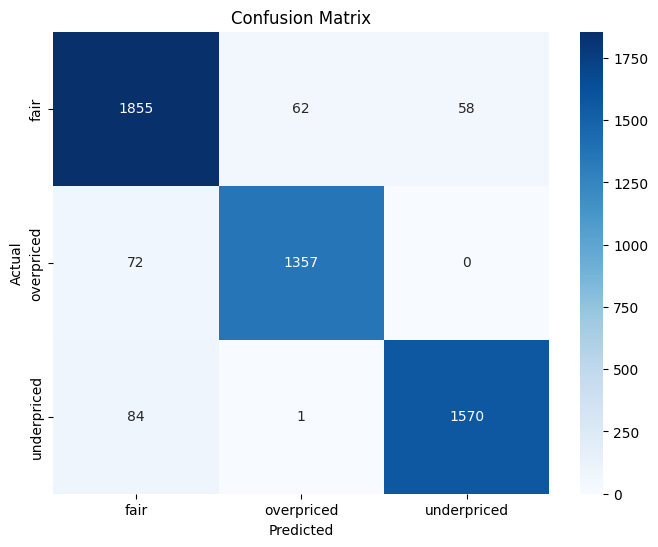

In [11]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['fair', 'overpriced', 'underpriced'],
            yticklabels=['fair', 'overpriced', 'underpriced'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [12]:
# Save the classifier
joblib.dump(classifier, '../models/complete_classifier_model.pkl')
print("Classifier saved as 'complete_classifier_model.pkl'")

# Save feature names for reference
classifier_features = list(X_classification.columns)
joblib.dump(classifier_features, '../models/classifier_feature_names.pkl')
print(f"Feature names saved. Total features: {len(classifier_features)}")
print(f"Features: {classifier_features}")

Classifier saved as 'complete_classifier_model.pkl'
Feature names saved. Total features: 20
Features: ['sq_feet', 'beds', 'baths', 'type_Townhouse', 'furnishing_Negotiable', 'furnishing_Unfurnished', 'type_Basement', 'type_Condo Unit', 'type_Main Floor', 'latitude', 'longitude', 'price', 'smoking_Non-Smoking', 'smoking_Smoke Free Building', 'cats_True', 'dogs_True', 'lease_term_6 months', 'lease_term_Long Term', 'lease_term_Negotiable', 'lease_term_Short Term']
